# 4th Week: Tutorial for Deep Learning with Audio
- Pitch classification
- Pitch regression
- Timbre classification


In [24]:
import torch
import torch.nn as nn
from math import pi
import IPython.display as ipd
import random
import matplotlib.pyplot as plt

In [25]:
torch.__version__

'1.9.0+cu102'

## 1. Make audio dataset
- We will use `torch` instead of `numpy` 
- Generate audio with 
  - Random frequency
  - Random number of harmonics
  - Random amplitude of harmonics
  - Plus white noise with random amplitude

In [135]:
SR = 16000
def make_sine_wave(freq, amp, dur, sr):
  num_samples = dur * sr
  time_frame = torch.arange(num_samples)
  time_frame_sec = time_frame / sr
  return amp * torch.sin(2 * pi * freq * time_frame_sec)

def make_sine_wave_with_random_harmonics(freq, amp, dur, sr, num_harm=7):
  fund = make_sine_wave(freq,amp,dur,sr)
  for i in range(2, num_harm):
    fund += make_sine_wave(freq * i, amp*random.random()/i**(1+random.random()), dur, sr)
  return fund

def make_white_noise(amp, dur, sr):
  return torch.randn(dur*sr)*amp

def make_pitch_class_dataset(n_samples_per_pitch):
  pitches = [440., 466.2, 493.8, 523.3, 554.4, 587.3,
            622.3, 659.3, 698.5, 740., 784.0, 830.6]
  pitch_name = ['A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb' ,'E', 'F', 'Gb', 'G', 'Ab']
  dataset = [make_sine_wave_with_random_harmonics(pitch, 0.3+random.random()/2, 3, SR, num_harm=0)+make_white_noise(random.random()*0.1, 3, SR) 
              for pitch in pitches for i in range(n_samples_per_pitch)]
  pitches = [i for i in range(len(pitch_name)) for j in range(n_samples_per_pitch)]
  dataset = torch.stack(dataset)
  pitches = torch.LongTensor(pitches)
  return dataset, pitches


def make_random_pitch_dataset(n_samples, pitch_range=(220,880)):
  min_pitch, max_pitch = pitch_range
  pitches = [random.randint(min_pitch,max_pitch) for i in range(n_samples)]
  dataset = [make_sine_wave_with_random_harmonics(pitch,0.3,3,SR)+make_white_noise(random.random()*0.2, 3, SR) for pitch in pitches]
  dataset = torch.stack(dataset)
  pitches = torch.Tensor(pitches)
  return dataset, pitches

dataset, pitches = make_pitch_class_dataset(100)


### 1-1 Shuffle Dataset and Label in random order

In [201]:
def shuffle_data_and_label(dataset, label):
  rand_ids = torch.randperm(dataset.shape[0])
  dataset = dataset[rand_ids]
  label = label[rand_ids]
  return dataset, label

dataset, pitches = shuffle_data_and_label(dataset, pitches)

### 1.1 Monitor dataset
1. Select random samples from dataset
2. Play the audio samples of the selected sample

In [100]:
rand_index = random.randint(0, dataset.shape[0]-1)
selected_sample = dataset[rand_index]
print(f'Frequency of selected sample is {pitches[rand_index]}')
ipd.Audio(selected_sample, rate=SR)

Frequency of selected sample is 7


## 1.2 Make Spectrogram
- 오디오 샘플을 처리하는 방법을 신경망이 학습하기 위해서는 데이터가 너무 많이 필요함
- 오디오 데이터는 STFT를 통해 Spectrogram으로 변환하는 것이 일반적

- Spectrogram

- MelSpectrogram

In [29]:
# install torchaudio
!pip install torchaudio==0.9.0
import torchaudio

In [187]:
spectrogram_converter = torchaudio.transforms.MelSpectrogram(n_fft=8192, sample_rate=SR, f_max=880, f_min=440, n_mels=48)
spectrogram = spectrogram_converter(dataset)
db_converter = torchaudio.transforms.AmplitudeToDB()
db_spectrogram = db_converter(spectrogram)

#### Plot Spectrogram
- Plot 2D spectrogram with `plt.imshow`
  - add `origin='lower'` to inverse y axis
- Plot 1D spectrum from a single frame of 2D spectrogram

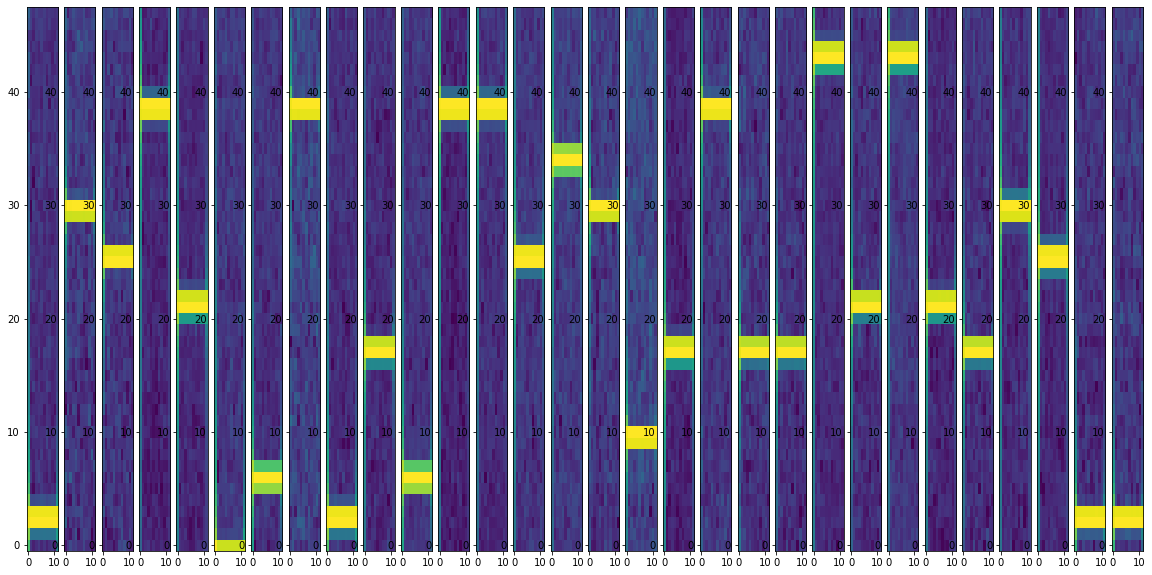

In [192]:
plt.figure(figsize=(20,10))
for i in range(30):
  plt.subplot(1,30,i+1)
  rand_index = random.randint(0, dataset.shape[0]-1)
  plt.imshow(db_spectrogram[rand_index], aspect='auto', interpolation='nearest', origin='lower')


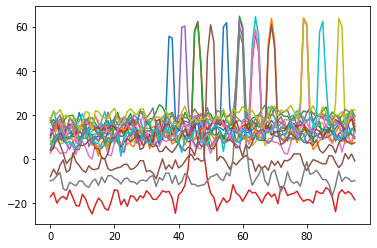

In [177]:
for i in range(20, 40):
  plt.plot(db_spectrogram[i,:, 1])

### 1.3 Split Dataset
- Training set: Dataset to train model parameters
- Test set: Dataset to test how the trained model works with unseen data

In [155]:
train_ratio = 0.8
num_samples = db_spectrogram.shape[0]
boundary = int(num_samples*train_ratio)
train_set = db_spectrogram[:boundary]
test_set = db_spectrogram[boundary:]
train_label = pitches[:boundary]
test_label = pitches[boundary:]

## 2. Make a Deep Neural Network Model
- Start with a simple model
- First Goal: make input and output right

In [82]:
class PitchClassifier(nn.Module):
  def __init__(self, n_mel=128, output_size=12):
    super().__init__()
    self.layer = nn.Linear(n_mel, output_size)
  
  def forward(self, x):
    out = self.layer(x)
    return out

pitch_classifier = PitchClassifier(13)

### 2-1 Test that the model can process our input
- Run with first 10 samples
- Handle spectrogram
  - Select only one frame
  - Use mean of entire time
  - Flatten every frame

In [60]:
selected_data = db_spectrogram[:10, :, 10] 
test_output = pitch_classifier(selected_data)

### 2-2 Softmax
- We want to select only one pitch class
  - that has maximum probability
- Softmax is a function that 

In [35]:
torch.set_printoptions(sci_mode=False)

In [61]:
def softmax(atensor, dim):
  exp = torch.exp(atensor)
  sum = torch.sum(exp, dim=dim, keepdim=True)
  return exp / sum

softmax(test_output, dim=-1)

tensor([[    0.0502,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.9498,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000],
        [    0.1989,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.7996,     0.0000,     0.0000,     0.0000,     0.0014,     0.0000],
        [    0.0003,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0002,     0.9970,     0.0026],
        [    0.0003,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.1009,     0.8983,     0.0000,     0.0000,     0.0004,     0.0000],
        [    0.0000,     0.0000,     0.9134,     0.0000,     0.0695,     0.0039,
             0.0000,     0.0001,     0.0001,     0.0000,     0.0000,     0.0129],
        [    0.9680,     0.0000,     0.0006,     0.0000,     0.0000,     0.0000,
             0.0010,     0.0000,     0.0000,     0.0000,     0.0303,     0.0001],
        [    0.0023,  

### 2-3 Loss
- Loss has to be zero if the prediction is perfect
- Loss has to be increased if the prediction gets worse
  - In pitch classification, we have only one correct class among 12 classes
    - Negative Log Likelihood with softmax

In [41]:
def get_loss(pred, target):
  pred_target_class = pred[torch.arange(len(pred)),target]
  return torch.mean(-torch.log(pred_target_class))
loss = get_loss(softmax(test_output, dim=-1), pitches[:10])
# torch_loss = torch.nn.functional.nll_loss(torch.log(softmax(test_output, dim=-1)), pitches[:10])
torch_loss = torch.nn.functional.cross_entropy(test_output, pitches[:10])

(tensor(13.9882, grad_fn=<MeanBackward0>),
 tensor(13.9882, grad_fn=<NllLossBackward>))

#### Backpropagation
- `loss.backward()` do backpropagation in `torch`
- The gradient of every parameters that was included in loss calculation will be calculated

### 2-4 Optimizer
- Optimizer helps to update neural network parameters
- There are various types of optimizers
- Most usual choice would be Adam
<img src=https://github.com/Jaewan-Yun/optimizer-visualization/raw/master/figures/movie9.gif>

In [43]:
optimizer = torch.optim.Adam(pitch_classifier.parameters())

#### Check optimizer works

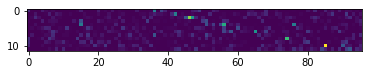

In [162]:
plt.imshow(pitch_classifier.layer.weight.detach() ** 4)

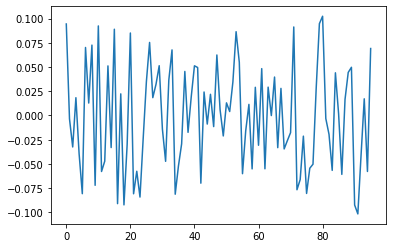

In [172]:
plt.plot(pitch_classifier.layer.weight[9].detach())

### 2-5 Make iteration loop

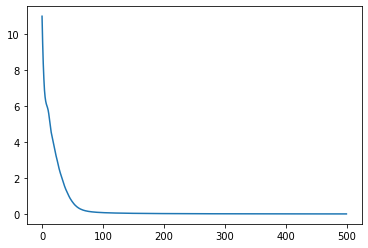

In [159]:
pitch_classifier = PitchClassifier(96)
num_epochs = 500
loss_record = []
optimizer = torch.optim.Adam(pitch_classifier.parameters())
for i in range(num_epochs):
  optimizer.zero_grad()
  pred = pitch_classifier(train_set[:,:, 3])
  softmax_pred = softmax(pred, dim=-1)
  loss = get_loss(softmax_pred, train_label)
  loss.backward()
  optimizer.step()
  loss_record.append(loss.item())



plt.plot(loss_record)

### 2-6 Test the result
- `with torcn.no_grad():` makes following codes runs without tracking gradient

In [140]:
  with torch.no_grad():
    pred = pitch_classifier(test_set[:,:, 10])
    pred_label = torch.argmax(pred, dim=-1)
  
  accuracy = torch.sum(pred_label == test_label) / len(pred_label)
  print(accuracy.item())

0.9958333373069763


## Pitch Regression

In [202]:
def make_random_pitch_dataset(n_samples, pitch_range=(220,880)):
  min_pitch, max_pitch = pitch_range
  pitches = [random.randint(min_pitch,max_pitch) for i in range(n_samples)]
  dataset = [make_sine_wave_with_random_harmonics(pitch,0.3,3,SR)+make_white_noise(random.random()*0.2, 3, SR) for pitch in pitches]
  dataset = torch.stack(dataset)
  pitches = torch.Tensor(pitches)
  return dataset, pitches

dataset, pitches = make_random_pitch_dataset(100)
dataset, pitches = shuffle_data_and_label(dataset,pitches)

In [ ]:

class Oscilator:
  def __init__(self, freq, amp, sr = 16000, num_harmonics=5):
    self.freq = freq
    self.amp = amp
    self.sr = sr
    self.num_harm = num_harmonics
    self.harm_amp = torch.randn(self.num_harm) 

  def generate(self, dur):
    return make_sine_wave(self.freq, self.amp, dur, self.sr)
  def generate_with_harmonics(self, dur):
    fund = self.generate(dur)
    for i in range(2, self.num_harm):
      fund += make_sine_wave(self.freq * i, self.amp*self.get_amp_of_harmonic(i), dur, self.sr)
    return fund
  def get_amp_of_harmonic(self, i):
    return self.harm_amp[i]


class ExampleGenerator:
  def __init__(self, sr=16000, num_pitches=12):
    self.sr = sr
    self.pitches = [random.randint(220, 880) for i in range(num_pitches)]
    self.oscils = [Oscilator(freq=pitch, amp=0.3, sr=sr) for pitch in self.pitches]

  def make_examples(self, dur, num_sample_per_pitch):
    return torch.stack([oscil.generate_with_harmonics(dur) for oscil in self.oscils])



## 2. Make torch Dataset

In [199]:
torch.exp(torch.Tensor([3, 1.5, 0.5, -1.0]))

tensor([20.0855,  4.4817,  1.6487,  0.3679])